In [1]:
# Import libraries for sound and display
import pandas as pd
import numpy as np
from os.path import join as pjoin
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import seaborn as sns
from scipy.spatial import distance

import multiprocessing as mp
import timeit
from tqdm import tqdm

import sklearn.preprocessing as pr

print("number of procesors: ", mp.cpu_count())


number of procesors:  16


We first begin with getting the data 

In [2]:
cleaned_corpus_path = "donateacry-corpus-master/donateacry_corpus_cleaned_and_updated_data"
label_list = os.listdir(cleaned_corpus_path)[:-1]
print(label_list)

file_label = []
file_path = []
file_label_test = []
file_path_test = []
for l in label_list:
    number_label = 0
    data_dir = pjoin(cleaned_corpus_path, l)
    for file in os.listdir(data_dir):
        path = pjoin(data_dir, file)
        if number_label < 5:
            file_path.append(path)
            file_label.append(l)
        else:
            file_path_test.append(path)
            file_label_test.append(l)
        number_label += 1
        if number_label >= 8:
            break

['hungry', 'discomfort', 'burping', 'belly_pain', 'tired']


In [3]:
label_df = pd.DataFrame(file_label, columns=["Cry"])
path_df = pd.DataFrame(file_path, columns=["Path"])
cry_df = pd.concat([label_df, path_df], axis=1)
label_df_test = pd.DataFrame(file_label_test, columns=["Cry"])
path_df_test = pd.DataFrame(file_path_test, columns=["Path"])
cry_df_test = pd.concat([label_df_test, path_df_test], axis=1)
print(cry_df.head())
print("------------------------------")
print(cry_df.tail())
print("------------------------------")
print(cry_df.Cry.value_counts())
print(cry_df_test.Cry.value_counts())

cry_df.to_csv("cry_path.cvs", index=False)
cry_df_test.to_csv("cry_path_test.cvs", index=False)

      Cry                                               Path
0  hungry  donateacry-corpus-master/donateacry_corpus_cle...
1  hungry  donateacry-corpus-master/donateacry_corpus_cle...
2  hungry  donateacry-corpus-master/donateacry_corpus_cle...
3  hungry  donateacry-corpus-master/donateacry_corpus_cle...
4  hungry  donateacry-corpus-master/donateacry_corpus_cle...
------------------------------
      Cry                                               Path
20  tired  donateacry-corpus-master/donateacry_corpus_cle...
21  tired  donateacry-corpus-master/donateacry_corpus_cle...
22  tired  donateacry-corpus-master/donateacry_corpus_cle...
23  tired  donateacry-corpus-master/donateacry_corpus_cle...
24  tired  donateacry-corpus-master/donateacry_corpus_cle...
------------------------------
hungry        5
discomfort    5
burping       5
belly_pain    5
tired         5
Name: Cry, dtype: int64
hungry        3
discomfort    3
burping       3
belly_pain    3
tired         3
Name: Cry, dtype: int6

Visualize some data

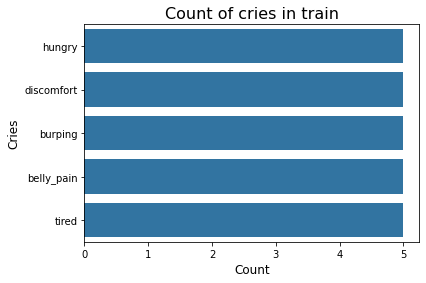

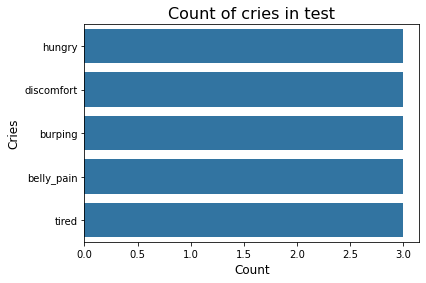

In [4]:
plt.title("Count of cries in train", size=16)
sns.countplot(cry_df.Cry)
plt.xlabel("Count", size=12)
plt.ylabel("Cries", size=12)
plt.show()
plt.title("Count of cries in test", size=16)
sns.countplot(cry_df_test.Cry)
plt.xlabel("Count", size=12)
plt.ylabel("Cries", size=12)
plt.show()

Data argumentation methods

In [5]:
# Add noise
def noise(data):
    noise_amp  = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# Stretch
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

# Shift
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5)*1000)
    return np.roll(data, shift_range)

# Pitch
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

Display normal audio

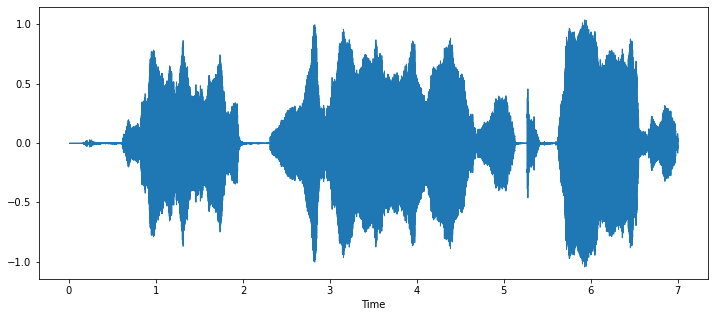

In [6]:
data, sr  = librosa.load(file_path[0])

plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)

Display audio with noise

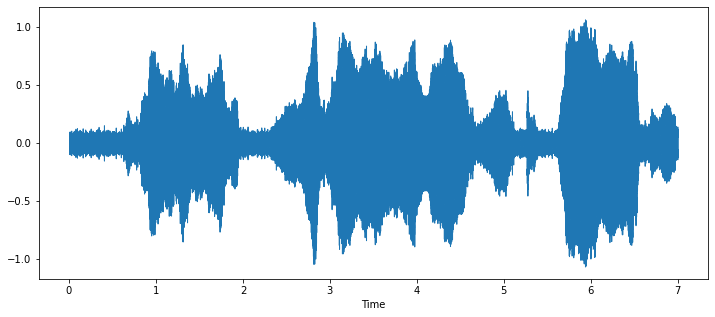

In [7]:
x = noise(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)

Display streched audio

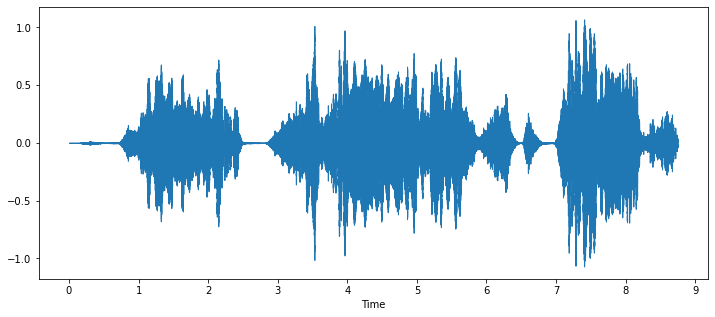

In [8]:
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)

Display shifted audio

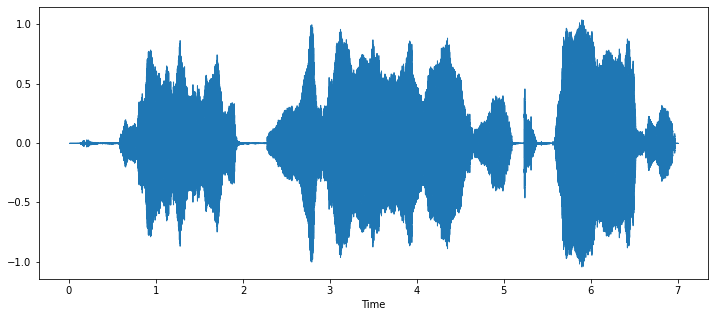

In [9]:
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)

Display pitched audio

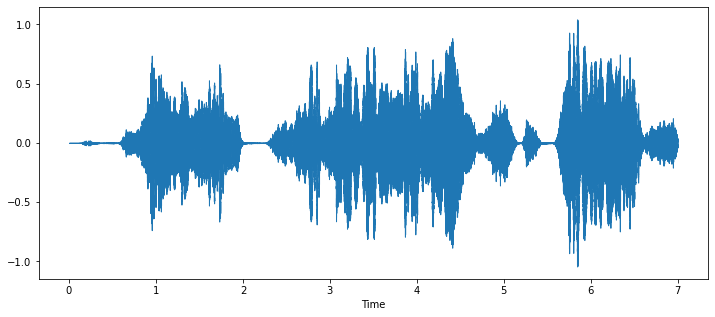

In [10]:
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)

Feature extraction methods

In [11]:
def shift_array(arr, shift_amount, fill_value = np.nan):
    '''Shifts the array either left or right by the shift_amount (which can be negative or positive)
     
       From: https://stackoverflow.com/a/42642326
    '''
    result = np.empty_like(arr)
    if shift_amount > 0:
        result[:shift_amount] = fill_value
        result[shift_amount:] = arr[:-shift_amount]
    elif shift_amount < 0:
        result[shift_amount:] = fill_value
        result[:shift_amount] = arr[-shift_amount:]
    else:
        result[:] = arr
    return result

def pad_zeros_right(s, padding_length):
    # https://numpy.org/doc/1.18/reference/generated/numpy.pad.html
    return np.pad(s, (0, padding_length), mode = 'constant', constant_values=0)

def align_peak(a, b, pad_function = None):
    # Aligns signals using cross correlation and then plots
    if(len(a) != len(b) and pad_function is None):
        raise Exception(f"Signal 'a' and 'b' must be the same size; len(a)={len(a)} and len(b)={len(b)} or pad_function must not be None")
    elif(len(a) != len(b) and pad_function is not None):
        if(len(a) < len(b)):
            a = pad_function(a, len(b) - len(a))
        else:
            b = pad_function(b, len(a) - len(b))
    
    correlate_result = np.correlate(a, b, 'full')
    
    best_correlation_index = np.argmax(correlate_result)
    shift_amount = (-len(a) + 1) + best_correlation_index
    return shift_array(b, shift_amount, 0)

def feature_scaling(feat):
    # Perform Feature Scaling
    feats = pr.scale(feat, axis=1)
    return feats.mean(), feats.var()

# Zero crossing rate
def zcr(data, frame_lenght, hop_length):
    cr = librosa.feature.zero_crossing_rate(data, frame_length=frame_lenght, hop_length=hop_length, pad=False)
    return np.mean(cr, axis=1), np.var(cr, axis=1)

# RMS Energy
def rmse(data, frame_lenght=2048, hop_length=512):
    rms = librosa.feature.rms(y=data, frame_length=frame_lenght, hop_length=hop_length)
    return np.mean(rms, axis=1), np.var(rms, axis=1)

# Mel-frequency cepstral coefficients
def mfcc(data, sr, flatten: bool=True):
    mfc = librosa.feature.mfcc(y=data, sr=sr)
    return np.mean(mfc, axis=1), np.var(mfc, axis=1)

# Chroma stft
def chroma(data, sr):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.mean(chroma_stft, axis=1), np.var(chroma_stft, axis=1)

# Harmonic and perceptuals
def harper(data):
    y_harm, y_perc = librosa.effects.hpss(y=data)
    return np.mean(y_harm), np.var(y_harm), np.mean(y_perc), np.var(y_perc)

# Beats per minute
def tempo(data, sr):
    tempo, beats = librosa.beat.beat_track(y=data, sr = sr)
    return tempo, np.mean(beats), np.var(beats)

# Spectral centroid
def specen(data, sr):
    spectral_centroids = librosa.feature.spectral_centroid(y=data, sr=sr)
    return np.mean(spectral_centroids, axis=1), np.var(spectral_centroids, axis=1)

# Spectral rolloff
def specroll(data, sr):
    spectral_rolloff = librosa.feature.spectral_rolloff(y=data, sr=sr)
    return np.mean(spectral_rolloff, axis=1), np.var(spectral_rolloff, axis=1)

def extract_features(data, sr, frame_lenght=2048, hop_length=512):
    zcr_mean, zcr_var = zcr(data, frame_lenght, hop_length)
    rmse_mean, rmse_var = rmse(data, frame_lenght, hop_length)
    mfcc_mean, mfcc_var = mfcc(data, sr)
    chroma_mean, chroma_var = chroma(data, sr)
    specroll_mean, specroll_var = specroll(data, sr)
    specen_mean, specen_var = specen(data, sr)
    temp, beat_mean, beat_var = tempo(data, sr)
    harm_mean, harm_var, perc_mean, perc_var = harper(data)
    
    result = {"tempo": temp, 
            "beat_mean": beat_mean, 
            "beat_var": beat_var,
            "harm_mean": harm_mean, 
            "harm_var": harm_var, 
            "perc_mean": perc_mean, 
            "perc_var": perc_var
    } 

    for y, featu in zip([[specen_mean, specen_var], [mfcc_mean, mfcc_var], [specroll_mean, specroll_var], [chroma_mean, chroma_var], [rmse_mean, rmse_var], [zcr_mean, zcr_var]], ["specen", "mfcc", "specroll", "chroma", "rms", "zcr"]):
        mea, vari = y[0], y[1]
        for m, v, i in zip(mea, vari, range(len(mea))):
            result[f"{featu}_mean_{i}"] = m
            result[f"{featu}_var_{i}"] = v
    #for da, i in zip(data, range(len(data))):
     #   result[f"data_{i}"] = da
    return result

def trim_silence(soundwave):
    return librosa.effects.trim(soundwave) # Remove leading and trailing silence

def get_features(path):
    read_in_sampling_rate = 6000 # 3,000 Hz is the lowest sampling rate that will play in Chrome
    data, sr = librosa.load(path, sr=read_in_sampling_rate)
    data, _ = librosa.effects.trim(data)
    # Remove noise
    data = librosa.effects.preemphasis(data)
    data = librosa.util.normalize(data)
    D = librosa.stft(data)
    db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    data, _ = librosa.effects.trim(data, top_db=np.abs(db[0])*0.50)
    # Give same peak to all audio
    
    aligner = np.zeros(data.shape[0] + 500)
    aligner[int((data.shape[0] + 500)/2)] = 1
    aligner[int((data.shape[0] + 500)/2) + 1] = -1
    data = align_peak(aligner, data, pad_function = pad_zeros_right)
    
    frame_size = int(sr * 0.5)  # 1.5 seconds
    hop_size = int(sr * 0.5)    # 0.5 seconds
    
    frames_ = librosa.util.frame(data, frame_length=frame_size, hop_length=hop_size, axis=0)
    aud_1 = []
    aud_2 = []
    aud_3 = []
    aud_4 = []
    frames = []
    for frame in frames_: 
        frame = librosa.effects.preemphasis(frame)
        frame, _ = librosa.effects.trim(frame)
        if len(frame) == 0:
            print("frame lenght equals 0")
            continue
        frames.append(frame)
            
        aud = extract_features(data, sr)
        aud_1.append(aud)

        noised_audio = noise(data)
        aud2 = extract_features(noised_audio, sr)
        aud_2.append(aud2)
        
        pitched_audio = pitch(data, sr)
        aud3 = extract_features(pitched_audio, sr)
        aud_3.append(aud3)

        pitched_audio_ = pitch(data, sr)
        pitched_noised_audio = noise(pitched_audio_)
        aud4 = extract_features(pitched_noised_audio, sr)
        aud_4.append(aud4)
            
    return aud_1, aud_2, aud_3, aud_4, frames


Get Features

In [12]:
start = timeit.default_timer()
X, Y = [], []
belly_pain, hungry, tired, burping, discomfort = [], [], [], [], []
belly_pain_test, hungry_test, tired_test, burping_test, discomfort_test = [], [], [], [], []
X_test, Y_test = [], []
index = 0
for path, cry in tqdm (zip(cry_df.Path, cry_df.Cry)):
    features, features2, features3, features4, frames = get_features(path)
    for f in range(len(frames)):
        if index % 50 == 0:
            print(f'{index}/{len(cry_df.Path)} audio has been processed')
        if cry == 'hungry':
            hungry.append(features[f])
            hungry.append(features2[f])
            hungry.append(features3[f])
            hungry.append(features4[f]) 
        elif cry == 'discomfort':
            discomfort.append(features[f])
            discomfort.append(features2[f])
            discomfort.append(features3[f])
            discomfort.append(features4[f]) 
        elif cry == 'burping':
            burping.append(features[f])
            burping.append(features2[f])
            burping.append(features3[f])
            burping.append(features4[f]) 
        elif cry == 'belly_pain': 
            belly_pain.append(features[f])
            belly_pain.append(features2[f])
            belly_pain.append(features3[f])
            belly_pain.append(features4[f]) 
        elif cry == 'tired':
            tired.append(features[f])
            tired.append(features2[f])
            tired.append(features3[f])
            tired.append(features4[f]) 
        else:
            print("unrecognized label")
            continue
        X.append(features[f])
        X.append(features2[f])
        X.append(features3[f])
        X.append(features4[f])
        Y.append(cry)
        Y.append(cry)
        Y.append(cry)
        Y.append(cry)
        index += 1

index_test = 0
for path_test, cry_test in tqdm (zip(cry_df_test.Path, cry_df_test.Cry)):
    features_test, features_test2, features_test3, features_test4, frames = get_features(path_test)
    for f in range(len(frames)):
        if index_test % 50 == 0:
            print(f'{index_test}/{len(cry_df.Path)} audio has been processed')
        if cry_test == 'hungry':
            hungry_test.append(features_test[f])
            hungry_test.append(features_test2[f])
            hungry_test.append(features_test3[f])
            hungry_test.append(features_test4[f]) 
        elif cry_test == 'discomfort':
            discomfort_test.append(features_test[f])
            discomfort_test.append(features_test2[f])
            discomfort_test.append(features_test3[f])
            discomfort_test.append(features_test4[f]) 
        elif cry_test == 'burping':
            burping_test.append(features_test[f])
            burping_test.append(features_test2[f])
            burping_test.append(features_test3[f])
            burping_test.append(features_test4[f])            
        elif cry_test == 'belly_pain': 
            belly_pain_test.append(features_test[f])
            belly_pain_test.append(features_test2[f])
            belly_pain_test.append(features_test3[f])
            belly_pain_test.append(features_test4[f])
        elif cry_test == 'tired':
            tired_test.append(features_test[f])
            tired_test.append(features_test2[f])
            tired_test.append(features_test3[f])
            tired_test.append(features_test4[f])
        else:
            print("unrecognized label")
            continue
        X_test.append(features_test[f])
        X_test.append(features_test2[f])
        X_test.append(features_test3[f])
        X_test.append(features_test4[f])
        Y_test.append(cry_test)
        Y_test.append(cry_test)
        Y_test.append(cry_test)
        Y_test.append(cry_test)
        index_test += 1             

print('Done extracting features')
stop = timeit.default_timer()
print('Time: ', stop - start) 
print("Number of trains: ", len(Y))
print("Number of tests: ", len(Y_test))

1it [00:06,  6.91s/it]

0/25 audio has been processed


5it [00:30,  6.08s/it]

50/25 audio has been processed


8it [00:50,  6.44s/it]

100/25 audio has been processed


12it [01:14,  6.16s/it]

150/25 audio has been processed


16it [01:42,  6.84s/it]

200/25 audio has been processed


20it [02:07,  6.40s/it]

250/25 audio has been processed


24it [02:33,  6.53s/it]

300/25 audio has been processed


25it [02:36,  6.26s/it]
1it [00:06,  6.32s/it]

0/25 audio has been processed


4it [00:27,  6.88s/it]

50/25 audio has been processed


8it [00:51,  6.04s/it]

100/25 audio has been processed


12it [01:19,  6.74s/it]

150/25 audio has been processed


15it [01:38,  6.54s/it]

Done extracting features
Time:  254.66339924600004
Number of trains:  1288
Number of tests:  800


In [13]:
print(f"({len(X)}, {len(Y)}, {cry_df.Path.shape})")

(1288, 1288, (25,))


Save features

In [14]:
tired_df = pd.DataFrame(tired)
tired_df = tired_df.fillna(0)
tired_df.to_csv("tired.csv", index=False)
tired_test_df = pd.DataFrame(tired_test)
tired_test_df = tired_test_df.fillna(0)
tired_test_df.to_csv("tired_test.csv", index=False)
discomfort_df = pd.DataFrame(discomfort)
discomfort_df = discomfort_df.fillna(0)
discomfort_df.to_csv("discomfort.csv", index=False)
discomfort_test_df = pd.DataFrame(discomfort_test)
discomfort_test_df = discomfort_test_df.fillna(0)
discomfort_test_df.to_csv("discomfort_test.csv", index=False)
hungry_df = pd.DataFrame(hungry)
hungry_df = hungry_df.fillna(0)
hungry_df.to_csv("hungry.csv", index=False)
hungry_test_df = pd.DataFrame(hungry_test)
hungry_test_df = hungry_test_df.fillna(0)
hungry_test_df.to_csv("hungry_test.csv", index=False)
belly_pain_df = pd.DataFrame(belly_pain)
belly_pain_df = belly_pain_df.fillna(0)
belly_pain_df.to_csv("belly_pain.csv", index=False)
belly_pain_test_df = pd.DataFrame(belly_pain_test)
belly_pain_test_df = belly_pain_test_df.fillna(0)
belly_pain_test_df.to_csv("belly_pain_test.csv", index=False)
burping_df = pd.DataFrame(burping)
burping_df = burping_df.fillna(0)
burping_df.to_csv("burping.csv", index=False)
burping_test_df = pd.DataFrame(burping_test)
burping_test_df = burping_test_df.fillna(0)
burping_test_df.to_csv("burping_test.csv", index=False)
Cries = pd.DataFrame(X)
#Cries = (Cries-Cries.min())/(Cries.max()-Cries.min())
Cries["Labels"] = Y
Cries = Cries.fillna(0)
Cries.to_csv("cries_8.csv", index=False)
Cries_test = pd.DataFrame(X_test)
#Cries_test = (Cries_test-Cries_test.min())/(Cries_test.max()-Cries_test.min())
Cries_test["Labels"] = Y_test
Cries_test = Cries_test.fillna(0)
Cries_test.to_csv("cries_8_test.csv", index=False)
Cries.head()

,tempo,beat_mean,beat_var,harm_mean,harm_var,perc_mean,perc_var,specen_mean_0,specen_var_0,mfcc_mean_0,...,chroma_var_9,chroma_mean_10,chroma_var_10,chroma_mean_11,chroma_var_11,rms_mean_0,rms_var_0,zcr_mean_0,zcr_var_0,Labels
0,175.781250,30.00,20.0000,-0.000002,0.000173,-3.370285e-07,0.063506,1119.355560,597932.720716,-250.758987,...,0.152893,0.266957,0.110903,0.159732,0.048189,0.187219,0.030227,0.347093,0.062708,hungry
1,175.781250,30.00,20.0000,0.000003,0.000176,5.393783e-06,0.063499,1598.038040,11535.710005,-181.721760,...,0.087936,0.425049,0.089087,0.350378,0.108856,0.188102,0.029898,0.508971,0.003690,hungry
2,87.890625,19.80,144.5600,-0.000002,0.000477,7.449444e-07,0.031466,1257.266597,518831.267293,-272.869202,...,0.152516,0.360396,0.124645,0.229052,0.062677,0.138419,0.016262,0.382944,0.060624,hungry
3,117.187500,23.25,180.1875,-0.000031,0.000739,-4.888541e-05,0.031521,1582.992331,7370.954265,-50.554428,...,0.080034,0.586235,0.073644,0.488380,0.076842,0.149797,0.013884,0.525046,0.003837,hungry
4,175.781250,30.00,20.0000,-0.000002,0.000173,-3.370285e-07,0.063506,1119.355560,597932.720716,-250.758987,...,0.152893,0.266957,0.110903,0.159732,0.048189,0.187219,0.030227,0.347093,0.062708,hungry
